In [93]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import csv
from ipywidgets import interact, FloatSlider
from scipy import signal


In [94]:
path = "Dataset\mitbih_database"
filenames = next(os.walk(path))[2]
records=list()
annotations=list()
filenames.sort()
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

In [95]:
def get_record_signals(index):
    signals = []
    labels = []
    with open(records[index],'r') as csvfile:
        filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
        row_index = -1
        for row in filereader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        signals = np.array(signals)
    with open(annotations[index],'r') as csvfile:
        filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
        row_index = -1
        for row in filereader:
            if(row_index >= 0):
                elements = list(filter(lambda x: len(x) > 0, row[0].split(" ")))
                labels.insert(row_index, [int(elements[1]), elements[2]])
            row_index += 1
        labels = np.array(labels)
    return signals, labels

In [96]:
signals, labels = get_record_signals(6)
print("Number of samples:", len(signals))
print("Value Range:", np.min(signals), "->", np.max(signals))
print("Classes:", np.unique(labels[:, 1]))

Number of samples: 650000
Value Range: 611 -> 1538
Classes: ['+' 'N' 'V' '~']


In [97]:
fs = 360.0
N = 650000
T = N / fs
t = np.linspace(0, T, N, endpoint=False)

In [98]:
# Detrend (usuniecie DC/linearna składowa)
data_detrended = signal.detrend(signals)

In [99]:
# Butterworth bandpass (np. 0.5 - 40 Hz)
lowcut = 0.5
highcut = 40.0
nyq = 0.5 * fs
b, a = signal.butter(4, [lowcut/nyq, highcut/nyq], btype='band')
data_filt = signal.filtfilt(b, a, data_detrended)  # zero-phase

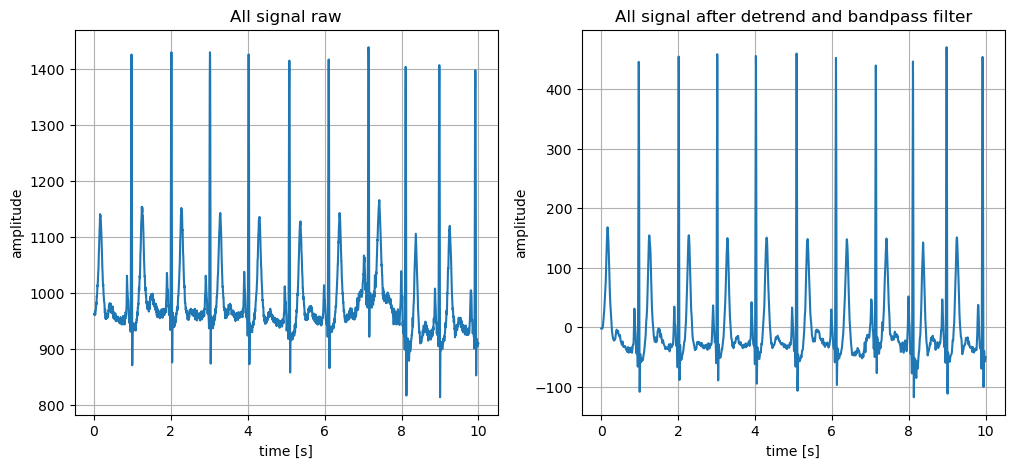

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(t[0:3600], signals[0:3600])
ax[0].set_title("All signal raw")
ax[0].set_xlabel("time [s]")
ax[0].set_ylabel("amplitude")
ax[0].grid(True)
ax[1].plot(t[0:3600], data_filt[0:3600])
ax[1].set_title("All signal after detrend and bandpass filter")
ax[1].set_xlabel("time [s]")
ax[1].set_ylabel("amplitude")
ax[1].grid(True)
plt.show()

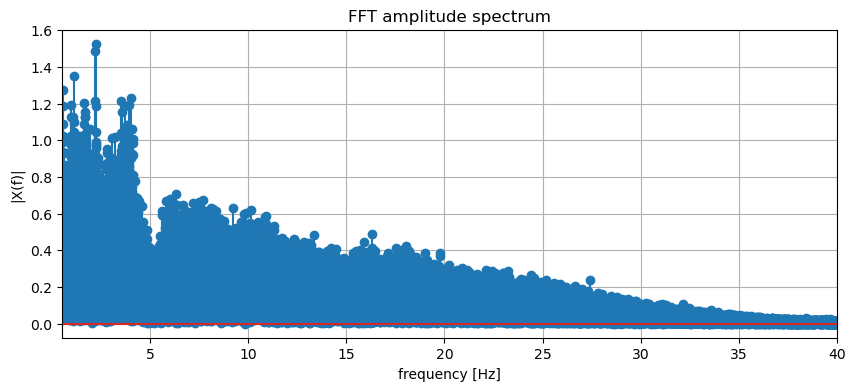

In [110]:
X = np.fft.fft(data_filt)              # liczby zespolone FFT
freqs = np.fft.fftfreq(N, 1/fs)  # oś częstotliwości (Hz)

# bierzemy tylko dodatnie częstotliwości
positive = freqs >= 0
freqs_pos = freqs[positive]
# normalizacja
X_pos = np.abs(X[positive]) / N

plt.figure(figsize=(10,4))
plt.stem(freqs_pos, X_pos)
plt.title("FFT amplitude spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("|X(f)|")
plt.xlim(0.5, 40)   # widmo do 10 Hz
plt.grid(True)
plt.show()

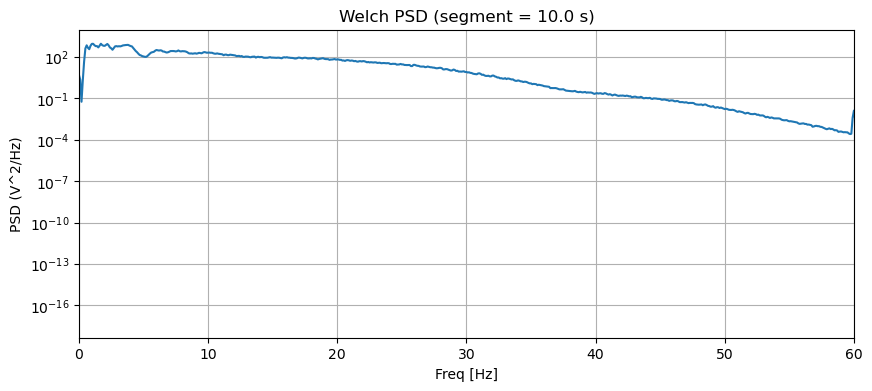

In [104]:
nperseg = int(fs * 10)   # 10 s okno
f_welch, Pxx = signal.welch(data_filt, fs=fs, nperseg=nperseg, noverlap=nperseg//2, window='hann')

plt.figure(figsize=(10,4))
plt.semilogy(f_welch, Pxx)
plt.xlim(0, 60)
plt.xlabel("Freq [Hz]")
plt.ylabel("PSD (V^2/Hz)")
plt.title("Welch PSD (segment = {} s)".format(nperseg/fs))
plt.grid(True)
plt.show()

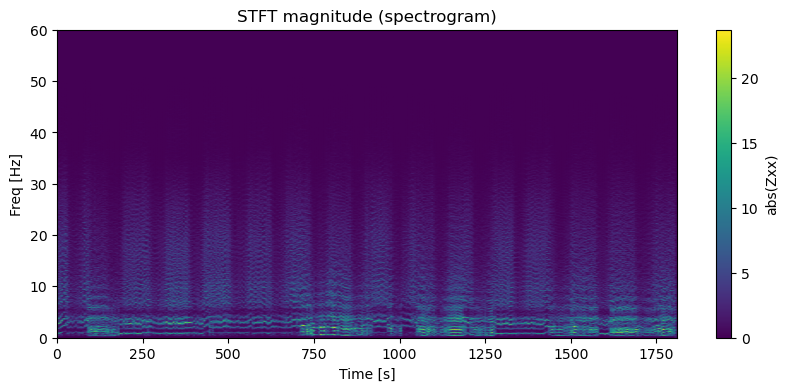

In [105]:
f_stft, t_stft, Zxx = signal.stft(data_filt, fs=fs, window='hann', nperseg=nperseg, noverlap=nperseg//2)
plt.figure(figsize=(10,4))
plt.pcolormesh(t_stft, f_stft, np.abs(Zxx), shading='gouraud')
plt.ylim(0, 60)
plt.xlabel("Time [s]")
plt.ylabel("Freq [Hz]")
plt.title("STFT magnitude (spectrogram)")
plt.colorbar(label='abs(Zxx)')
plt.show()

In [ ]:
# import pywt

# temp_signal = signals

# def denoise(data): 
#     w = pywt.Wavelet('sym4')
#     maxlev = pywt.dwt_max_level(len(data), w.dec_len)
#     threshold = 0.04 # Threshold for filtering

#     coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
#   #  print(len(coeffs))
#     for i in range(1, len(coeffs)):
#         coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
#     datarec = pywt.waverec(coeffs, 'sym4')
#     return datarec

# temp_signal=denoise(temp_signal)
# plt.plot(temp_signal[:1500])
# plt.xlabel('Samples', fontsize=15)
# plt.ylabel('Voltage (Millivolts)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig('after_denoising')

# from scipy import stats

# temp_signal = stats.zscore(temp_signal)
# plt.plot(temp_signal[:700])
# plt.xlabel('Samples', fontsize=15)
# plt.ylabel('Voltage (Millivolts)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig('after_norm')